In [78]:
import matplotlib
import matplotlib.pyplot as plt

import matplotlib.dates as mdates
import numpy as np
from datetime import datetime
import pandas as pd
from matplotlib.animation import FuncAnimation
import geopandas as gpd
import threedigrid
from threedigrid.admin.gridresultadmin import GridH5ResultAdmin
from threedigrid.admin.gridadmin import GridH5Admin

import uuid

In [79]:
from __my_functions_flooddepth_houses import get_time_dimensions_flood
from __my_functions_flooddepth_houses import create_df_flooddepth_houses
from __my_functions_flooddepth_houses import create_sample_houses_withinZone
from __my_functions_flooddepth_houses import calculate_first_qth_arrival_and_maxdepth
from __my_functions_flooddepth_houses import plot_flooddepth_houses_in_zone

### paths

In [80]:
## flood results paths
# floodresults_path = '/Users/louiseklingen/Documents/TU/modelresults/modelresults_denhelder' 
floodresults_path = 'E:/projecten/P2019_1_DenHelderOverstroming/data_en_modellen/modelresults' 

In [81]:
general_path = 'E:\paper2_analysis/depth_arrival_zones'
figures_path = f'{general_path}/figures'
input_path = f'{general_path}/input'
output_path = f'{general_path}/output'

-----------------------

### load flood results

In [148]:
# ## flood scenario 
# scenario_name = 'scen1_voorpiek'
# simulation_name = 'lk_dh_test13_5verloop_2d'
# ## start_breach_time = '2000-01-01T18:00:00'
# start_breach_time = '2000-01-01T00:00:00'


scenario_name = 'scen2_napiek'
simulation_name = 'lk_dh_test14_5verloop_38h'
# start_breach_time = '2000-01-02T04:00:00'
start_breach_time = '2000-01-01T00:00:00'

In [149]:
## flood result files
netcdf_file = (f'{floodresults_path}/{simulation_name}/results_3di.nc')
gridadmin_file = (f'{floodresults_path}/{simulation_name}/gridadmin.h5')
gr = GridH5ResultAdmin(gridadmin_file , netcdf_file)
ga = GridH5Admin(gridadmin_file)

In [150]:
time_humanized, last_timestamp  = get_time_dimensions_flood(gr, start_breach_time)

rekentijd: 38.00862374799665 uur
aantal tijdstappen: 457
interval: 300.02, secondes = 5.0 min
 breach start time at: 2000-01-01 00:00:00


----------------

## load buurten and houses in area

In [151]:
buurten_scen2_test = gpd.read_file(f'{input_path}/buurten_scen2_test.shp')
# buurten_scen2_test.columns

In [152]:
houses_all = gpd.read_file(f'{input_path}/huizen_centroid_flood_area_cleaned.shp')

------------------------------------------------------------

##  one random zone for testing

In [134]:
random_index = 35
selected_zone = buurten_scen2_test.iloc[random_index]
selected_zone_geom = selected_zone.geometry
# selected_zone_geom

In [135]:
#oude sluis
selected_zone = buurten_scen2_test.loc[buurten_scen2_test.BU_CODE == 'BU04410901']
selected_zone_geom = selected_zone.geometry

#### alle functies los voor debugging

#### 1) create sample

nr houses in 67    Oudesluis (woonkern)
Name: BU_NAAM, dtype: object: 0
all houses in zones taken
67    Oudesluis (woonkern)
Name: BU_NAAM, dtype: object


C:\Users\Louise\anaconda3\envs\geo\lib\site-packages\geopandas\base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
C:\Users\Louise\anaconda3\envs\geo\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\Louise\anaconda3\envs\geo\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


,h_maaiveld,dak_type,huis_id,cell_id,sumax,z_cell,geometry


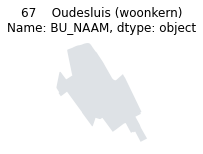

In [136]:
samplesize = 30
zone_name, houses_df = create_sample_houses_withinZone(samplesize, houses_all, selected_zone )
print(zone_name)
houses_df.head(1)

In [137]:
len(houses_df)

0

#### 2)  compute flood depth(t)at this sample

In [112]:
if len(flooddepth_time_houses_df.columns) > 0:
    flooddepth_time_houses_df = create_df_flooddepth_houses(scenario_name, samplesize, zone_name,
                                                                houses_df, gr, time_humanized, last_timestamp, output_path)
    flooddepth_time_houses_df.tail(1)
else:
    continue

#### 3)  compute one value first arrival and max depth for zone

In [17]:
first_qth_arrival, max_depth = calculate_first_qth_arrival_and_maxdepth(flooddepth_time_houses_df)
first_qth_arrival, max_depth 

(datetime.datetime(2000, 1, 1, 1, 0, 3), 3.324850754050397)

#### 4) plot flood depth in zone

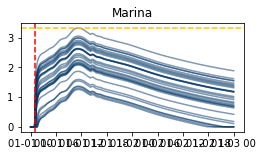

In [18]:
plot_flooddepth_houses_in_zone(zone_name,flooddepth_time_houses_df, first_qth_arrival,max_depth, time_humanized)

----------------------------

## selection of zones

In [138]:
len_all_zones = len(buurten_scen2_test)
len_all_zones

90

#### choose sample size

In [153]:
nr_zones_sampling = 90
samplesize_nr_houses_in_zone = 15

In [154]:
selected_zones = buurten_scen2_test.sample(nr_zones_sampling)

In [155]:
zones_maxdepth_arrival_df = selected_zones[["BU_NAAM", 'geometry', 'AANT_INW']].copy()
zones_maxdepth_arrival_df["maxdepth"] = np.nan
zones_maxdepth_arrival_df["arrival"] = np.nan
# zones_maxdepth_arrival_df

nr houses in Jeruzalem: 748
too many, therefor sample of 15 houses taken
nr houses in Zeeloodsenbuurt: 1056
too many, therefor sample of 15 houses taken
nr houses in Golfstroombuurt: 429
too many, therefor sample of 15 houses taken
nr houses in Waterkeringsbuurt: 561
too many, therefor sample of 15 houses taken
nr houses in Vogelbuurt: 1770
too many, therefor sample of 15 houses taken
nr houses in Julianadorp-Oost: 493
too many, therefor sample of 15 houses taken
nr houses in Centrum: 610
too many, therefor sample of 15 houses taken
nr houses in Doorzwin: 1313
too many, therefor sample of 15 houses taken
nr houses in Nieuwesluis: 0
all houses in zones taken
nr houses in Julianadorp-West: 443
too many, therefor sample of 15 houses taken


C:\Users\Louise\anaconda3\envs\geo\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\Louise\anaconda3\envs\geo\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


nr houses in Kleine Rivierenbuurt: 237
too many, therefor sample of 15 houses taken


C:\Users\Louise\Documents\python_omnitrans\__my_functions_flooddepth_houses.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(2, 2))


nr houses in Noorderhaven: 124
too many, therefor sample of 15 houses taken
nr houses in Westerland: 0
all houses in zones taken
nr houses in Verspreide huizen Slootdorp: 0
all houses in zones taken


C:\Users\Louise\anaconda3\envs\geo\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\Louise\anaconda3\envs\geo\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\Louise\anaconda3\envs\geo\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\Louise\anaconda3\envs\geo\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


nr houses in Buitengebied 't Zand-West: 44
too many, therefor sample of 15 houses taken
nr houses in Blauwe Keet: 49
too many, therefor sample of 15 houses taken
nr houses in Kruiszwin: 1650
too many, therefor sample of 15 houses taken
nr houses in Visbuurt: 1913
too many, therefor sample of 15 houses taken
nr houses in Indische buurt-Noord: 700
too many, therefor sample of 15 houses taken
nr houses in De Stolpen en Buitengebied: 3
all houses in zones taken
nr houses in Oostoever: 105
too many, therefor sample of 15 houses taken
nr houses in Wieringerwaard: 0
all houses in zones taken
nr houses in Sluisdijk: 531
too many, therefor sample of 15 houses taken


C:\Users\Louise\anaconda3\envs\geo\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\Louise\anaconda3\envs\geo\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


nr houses in Zwanenbalg: 230
too many, therefor sample of 15 houses taken
nr houses in 't Zand-West- en -Zuid: 22
too many, therefor sample of 15 houses taken
nr houses in Landmetersbuurt: 1038
too many, therefor sample of 15 houses taken
nr houses in Dirksz Admiraal: 260
too many, therefor sample of 15 houses taken
nr houses in Breezand: 2414
too many, therefor sample of 15 houses taken
nr houses in Koegras-Noord: 113
too many, therefor sample of 15 houses taken
nr houses in Oostpolder: 204
too many, therefor sample of 15 houses taken
nr houses in Indische buurt-Zuid: 765
too many, therefor sample of 15 houses taken
nr houses in Boterzwin: 642
too many, therefor sample of 15 houses taken
nr houses in Buitengebied Callantsoog-Noord: 199
too many, therefor sample of 15 houses taken
nr houses in Kleine Sluis inclusief Spoorbuurt: 4543
too many, therefor sample of 15 houses taken
nr houses in Buitengebied 't Zand-Oost: 87
too many, therefor sample of 15 houses taken
nr houses in Uyterland

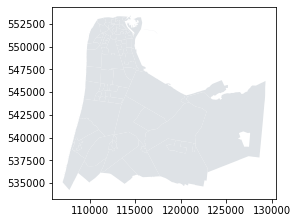

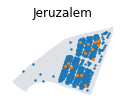

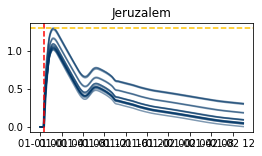

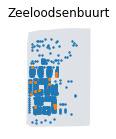

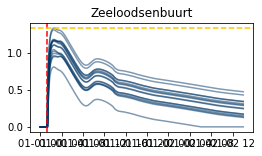

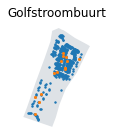

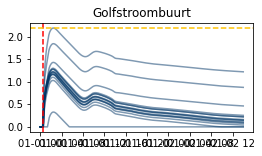

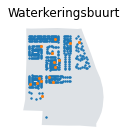

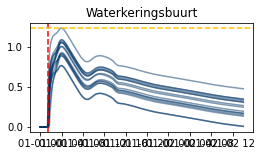

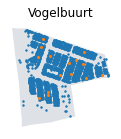

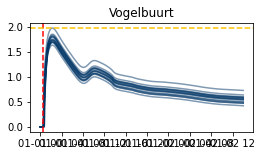

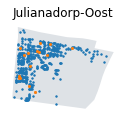

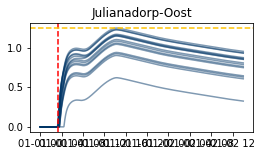

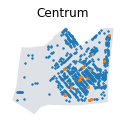

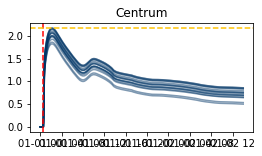

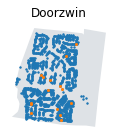

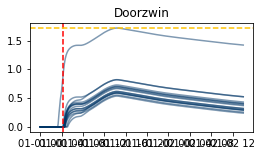

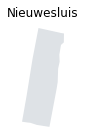

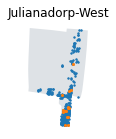

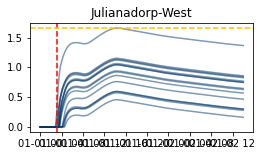

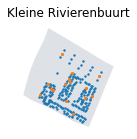

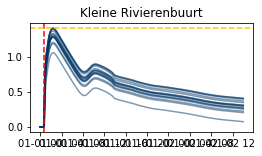

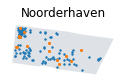

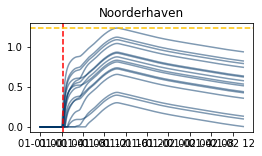

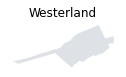

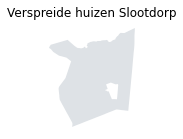

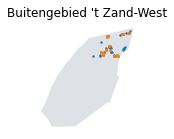

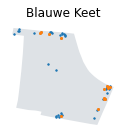

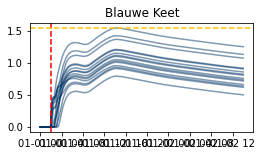

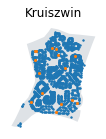

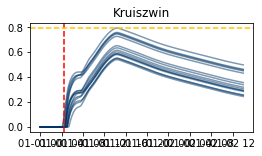

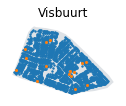

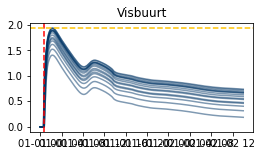

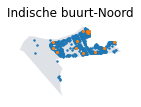

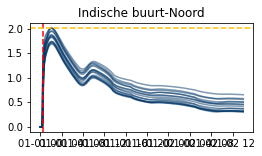

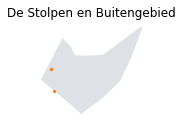

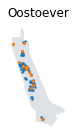

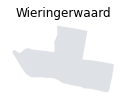

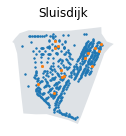

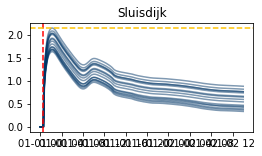

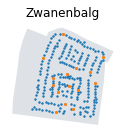

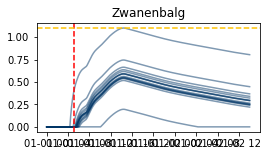

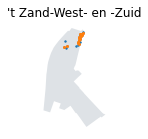

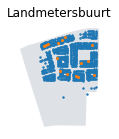

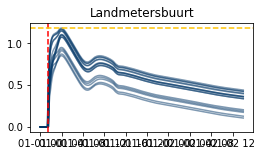

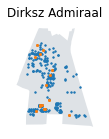

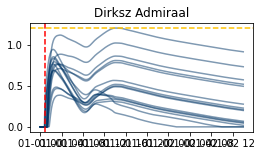

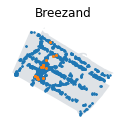

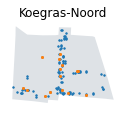

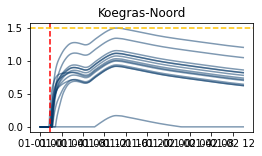

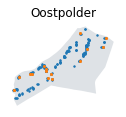

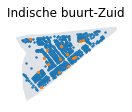

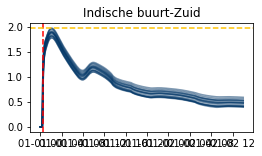

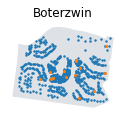

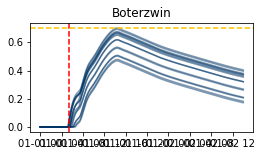

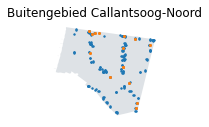

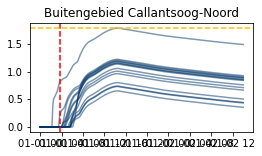

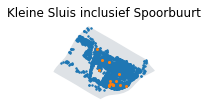

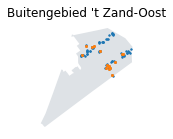

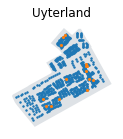

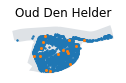

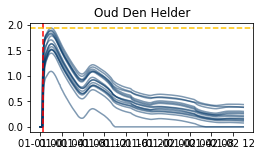

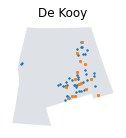

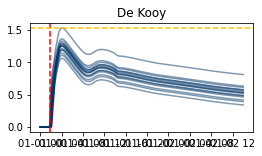

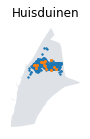

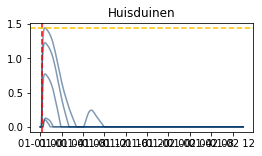

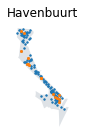

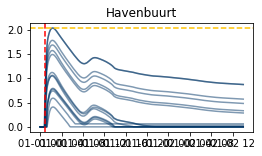

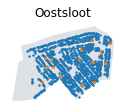

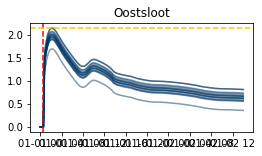

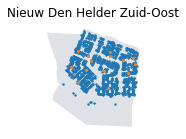

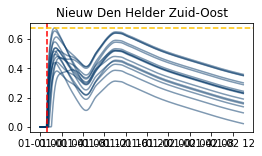

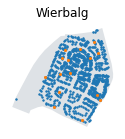

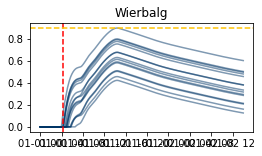

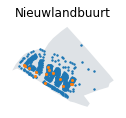

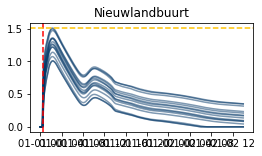

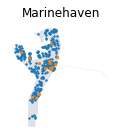

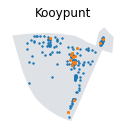

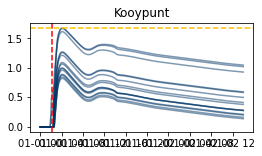

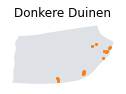

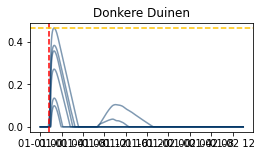

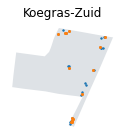

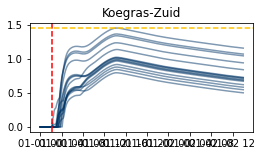

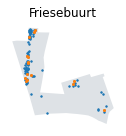

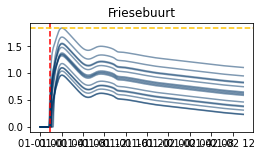

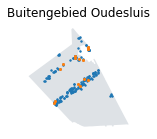

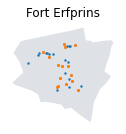

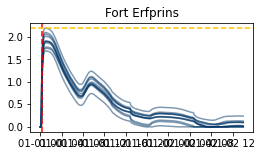

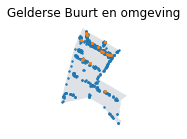

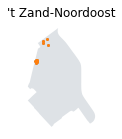

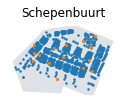

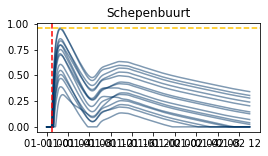

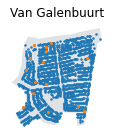

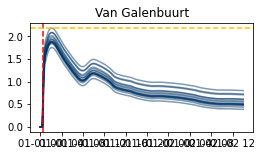

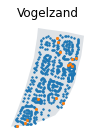

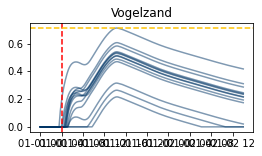

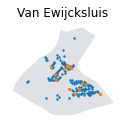

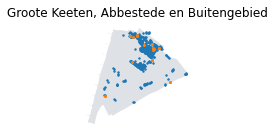

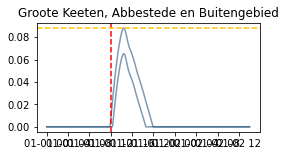

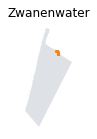

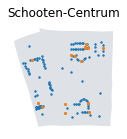

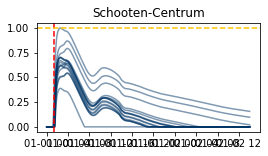

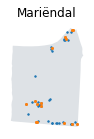

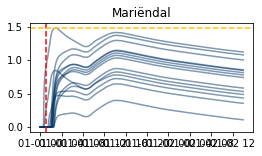

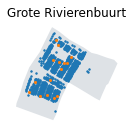

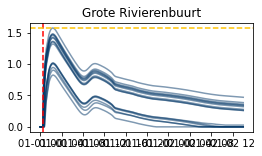

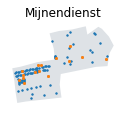

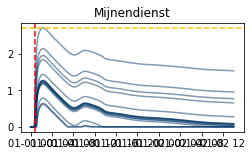

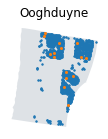

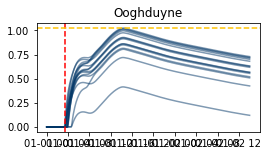

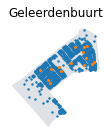

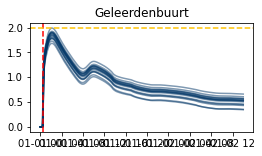

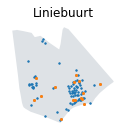

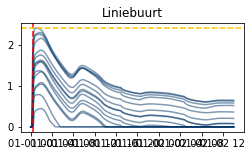

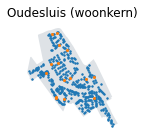

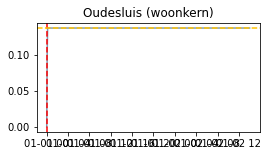

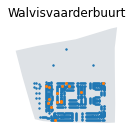

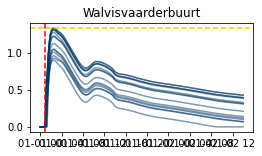

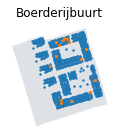

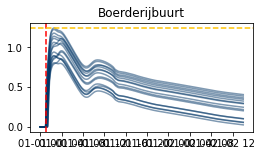

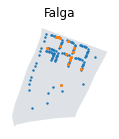

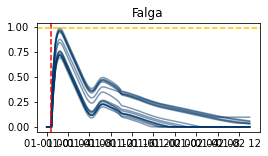

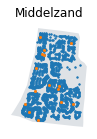

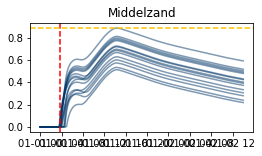

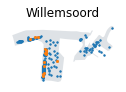

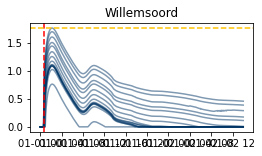

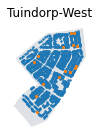

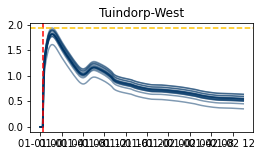

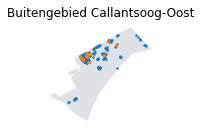

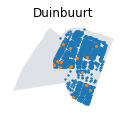

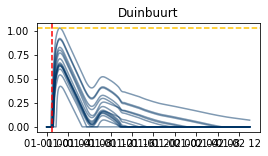

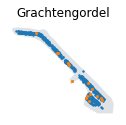

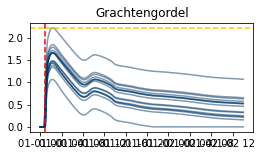

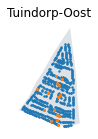

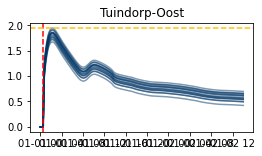

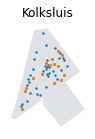

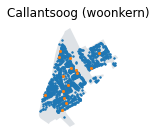

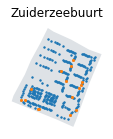

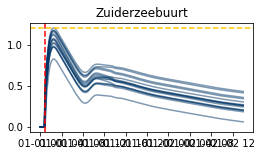

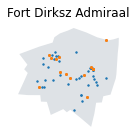

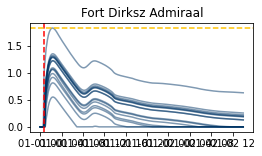

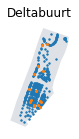

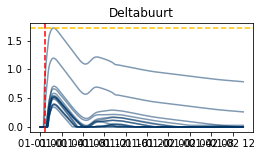

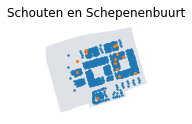

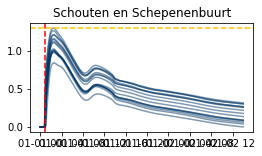

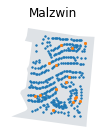

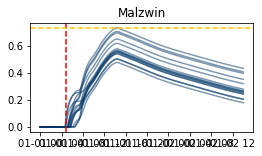

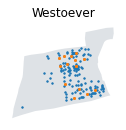

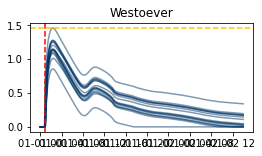

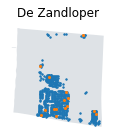

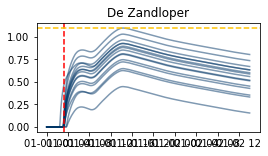

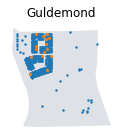

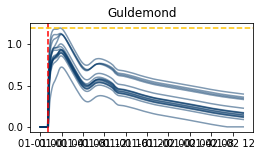

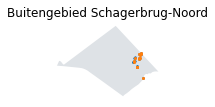

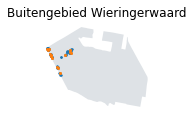

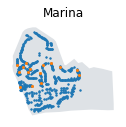

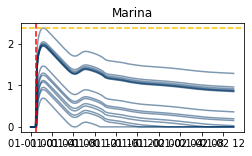

In [156]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)

samplesize = samplesize_nr_houses_in_zone

for index, row in zones_maxdepth_arrival_df.iterrows():
    gpd.GeoSeries(row.geometry).plot(ax=ax, color="#dee2e6")
    
    #create sample for all seleced zones
    zone_name, houses_df = create_sample_houses_withinZone(samplesize, houses_all, selected_zone = row )

    #indien er geen huizen in de zone zijn, continue to next loop
    if len(houses_df) == 0:
        continue
        
    else:
    
        # compute flood depth(t)at this sample
        flooddepth_time_houses_df = create_df_flooddepth_houses(scenario_name, samplesize, zone_name,
                                                                houses_df, gr, time_humanized, last_timestamp, output_path)
        
        ## continue when no depth
        if len(flooddepth_time_houses_df.columns) == 0:
            continue
            
        else:
            
            # compute one value first arrival and max depth for zone
            first_qth_arrival_dt, max_depth  = calculate_first_qth_arrival_and_maxdepth(flooddepth_time_houses_df)

            if max_depth > 0:
                zones_maxdepth_arrival_df.loc[index, "maxdepth"] = max_depth

            if datetime.timestamp(first_qth_arrival_dt) > 0:
                zones_maxdepth_arrival_df.loc[index, "arrival"] = first_qth_arrival_dt


        #plot flood depth in zone
        plot_flooddepth_houses_in_zone(zone_name,flooddepth_time_houses_df, first_qth_arrival_dt,max_depth, time_humanized)



In [157]:
zones_maxdepth_arrival_df

,BU_NAAM,geometry,AANT_INW,maxdepth,arrival
21,Jeruzalem,"POLYGON ((111549.898 551412.375, 111507.703 55...",970,1.295535,2000-01-01 00:40:04
38,Zeeloodsenbuurt,"POLYGON ((114598.102 550882.188, 114642.602 55...",1290,1.330532,2000-01-01 01:20:04
25,Golfstroombuurt,"POLYGON ((111634.398 551496.875, 111642.898 55...",710,2.188432,2000-01-01 00:30:04
42,Waterkeringsbuurt,"POLYGON ((113979.602 549749.813, 114000.500 54...",570,1.240926,2000-01-01 01:30:04
8,Vogelbuurt,"POLYGON ((112994.000 552072.000, 113043.500 55...",1855,1.972926,2000-01-01 00:35:04
...,...,...,...,...,...
53,De Zandloper,"MULTIPOLYGON (((109617.583 547478.374, 109599....",135,1.100330,2000-01-01 03:10:04
43,Guldemond,"POLYGON ((114018.500 549930.625, 114054.500 54...",745,1.197367,2000-01-01 01:27:04
66,Buitengebied Schagerbrug-Noord,"POLYGON ((115275.532 535924.900, 115259.677 53...",175,NaN,NaN
89,Buitengebied Wieringerwaard,"POLYGON ((118826.602 539862.375, 118923.602 53...",430,NaN,NaN


In [158]:
zones_maxdepth_arrival_df_dropna = zones_maxdepth_arrival_df.dropna()

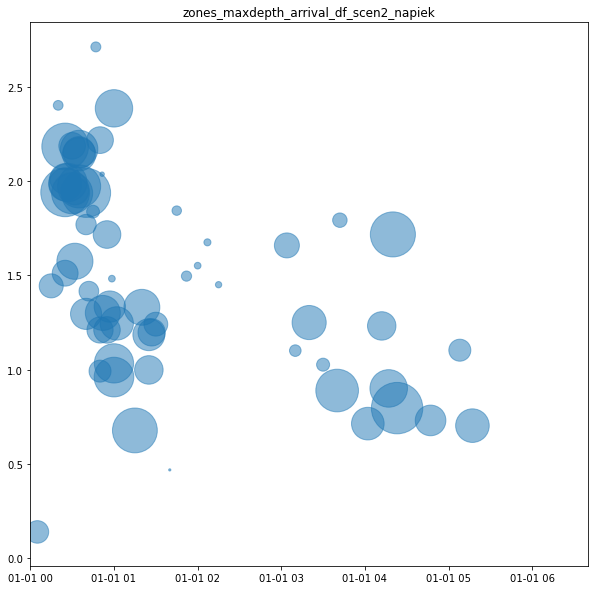

In [162]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

df = zones_maxdepth_arrival_df_dropna.copy()

ax.scatter(df.arrival, df.maxdepth,s = df.AANT_INW, alpha= 0.5 )
ax.set_xlim(time_humanized[0],time_humanized[80] )

ax.set_title(f'zones_maxdepth_arrival_df_{scenario_name}') 

plt.savefig(f'{figures_path}/zones_maxdepth_arrival_df_{scenario_name}_{nr_zones_sampling}.png', dpi=300)  
plt.savefig(f'{figures_path}/zones_maxdepth_arrival_df_{scenario_name}_{nr_zones_sampling}.svg', dpi=300)  


In [160]:
#datetime to string for export
zones_maxdepth_arrival_df_str = zones_maxdepth_arrival_df.copy()
zones_maxdepth_arrival_df_str['arrival'] = zones_maxdepth_arrival_df["arrival"].apply(str)
zones_maxdepth_arrival_df_str.to_file(f'{output_path}/zones_maxdepth_arrival_df_{scenario_name}_{nr_zones_sampling}.geojson', drive="GeoJSON")


C:\Users\Louise\anaconda3\envs\geo\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [ ]:
def plot_flooddepth_houses_in_zone(zone_name, flooddepth_time_houses_df,first_qth_arrival,max_depths_qth, time_humanized):
    fig = plt.figure(figsize=(2, 2))
    ax = fig.add_subplot(1, 1, 1)

    for label, content in flooddepth_time_houses_df.items():
        ax.plot(content, c = '#003566', alpha = 0.5)

    ax.set_xlim(time_humanized[0],time_humanized[40])
    ax.axvline(x = first_qth_arrival, color = 'r', linestyle ='--')
    ax.axhline(max_depths_qth, color= '#ffc300', linestyle ='--')
    plt.title(f'{zone_name}')
